In [39]:
import pandas as pd
from deap import base, creator, tools, algorithms
import numpy as np
import jenkspy
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [40]:
df = pd.read_csv("../data/df_score.csv", index_col=[0])

In [90]:
df["date_mensuelle"] = pd.to_datetime(df["date_mensuelle"])

# Jenks

In [41]:
scores_clients = df["Score_ind"]
nombre_de_classes = 6 

breaks = jenkspy.jenks_breaks(scores_clients, nombre_de_classes)
print(breaks)

[0.0, 106.38297872340424, 314.8936170212765, 434.0425531914893, 540.4255319148936, 685.1063829787233, 1000.0]


In [71]:
breaks = [0, 150, 300, 460, 540, 700, 800]

df["Classes"] = np.digitize(df["Score_ind"], bins=sorted(breaks))

resultats = df.groupby("Classes").agg(
    moyenne_TARGET=("TARGET", "mean"),
    nb_individus=("TARGET", "size")
)
resultats['taux_individus'] = (resultats['nb_individus'] / df.shape[0]) * 100

print(resultats)

         moyenne_TARGET  nb_individus  taux_individus
Classes                                              
1              0.173633         10384        3.392278
2              0.111024         71327       23.301329
3              0.080767         65064       21.255313
4              0.066295         62237       20.331779
5              0.050083         60979       19.920812
6              0.036548         22792        7.445762
7              0.037001         13324        4.352726


In [72]:
df["date_mensuelle"] = pd.to_datetime(df["date_mensuelle"])
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)

In [73]:
def plot_stability_taux(train, variable):
    stability_df = train.groupby(['date_trimestrielle', variable])['TARGET'].mean().unstack()
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

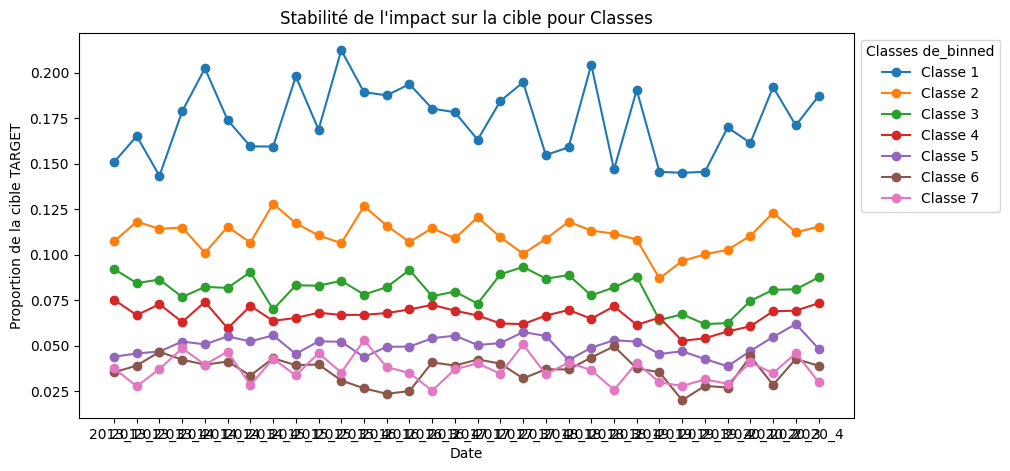

In [74]:
plot_stability_taux(df, "Classes")

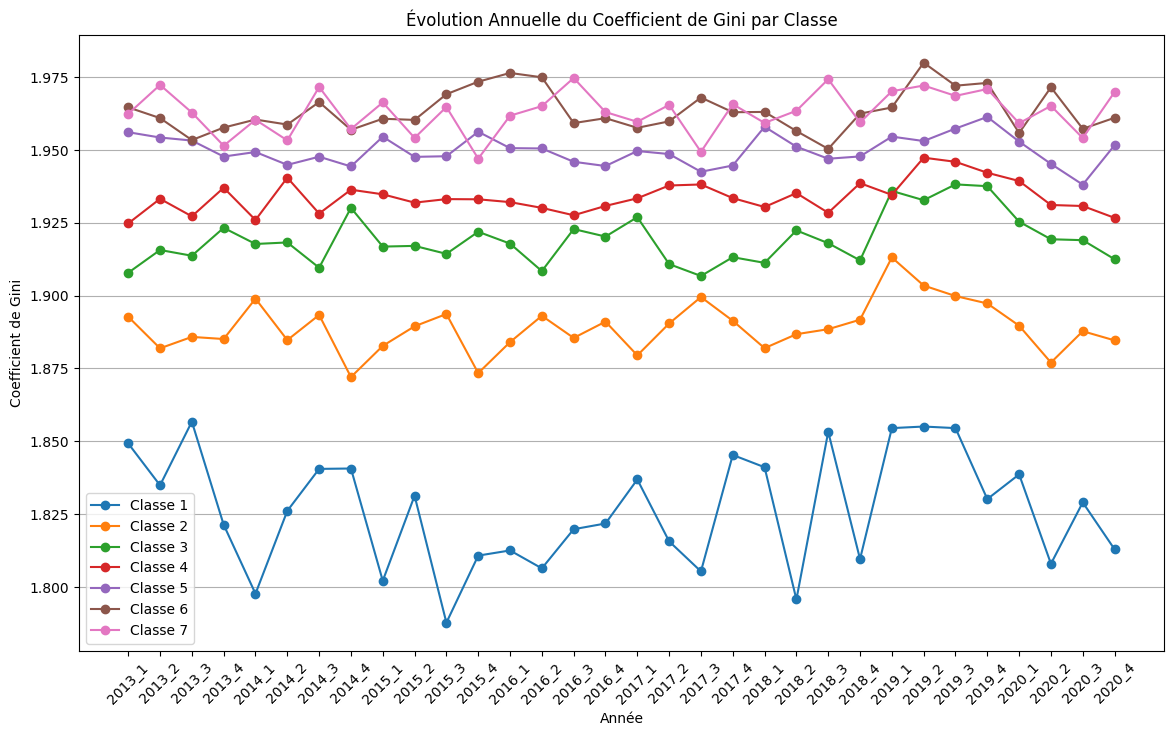

In [75]:
def gini_coefficient(values):
    sorted_values = np.sort(values)
    n = len(values)
    cumulative_values_sum = np.cumsum(sorted_values)
    gini_index = (2 * np.sum(cumulative_values_sum) / (n * np.sum(sorted_values))) - (n + 1) / n
    return 1 - gini_index

plt.figure(figsize=(14, 8))

for classe in range(1, 8): 
    df_classe = df[df['Classes'] == classe][["date_trimestrielle", "TARGET"]]
    grouped = df_classe.groupby(df_classe['date_trimestrielle'])["TARGET"]
    gini_per_year = grouped.apply(gini_coefficient)
    
    plt.plot(gini_per_year.index, gini_per_year, label=f'Classe {classe}', marker='o')

plt.title('Évolution Annuelle du Coefficient de Gini par Classe')
plt.xlabel('Année')
plt.ylabel('Coefficient de Gini')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [113]:
df.to_csv("../data/df_segmentation.csv")

# MOC C

In [76]:
resultats = df.groupby("Classes").agg(moyenne_TARGET=("TARGET", "mean")).to_dict()["moyenne_TARGET"]

In [77]:
resultats

{1: 0.17363251155624038,
 2: 0.11102387595160318,
 3: 0.08076662977990902,
 4: 0.06629496923052204,
 5: 0.05008281539546401,
 6: 0.036547911547911545,
 7: 0.03700090063044131}

In [78]:
def Boostrapping_Classes(classe):
    df_classe = df[df['Classes'] == classe]
    tx_defaut_liste = []

    for _ in range(1000):
        echantillon = df_classe["TARGET"].sample(n=len(df_classe), replace=True)
        tx_defaut_liste.append(echantillon.mean())
        
    tx_defaut_liste = np.array(tx_defaut_liste)

    decile9 = np.percentile(tx_defaut_liste, 90)

    MOC_C = decile9 - resultats[classe]
    
    return(classe, resultats[classe], decile9, MOC_C)

In [79]:
MOC_C = pd.DataFrame(columns = ["Classe", "LRA", "Décile9", "Moc_C"])

In [80]:
for i in range(1,8):
    classe, LRA, decile9, MOC_C_classe = Boostrapping_Classes(i)
    MOC_C.loc[len(MOC_C)] = [classe, LRA, decile9, MOC_C_classe]

In [81]:
MOC_C

,Classe,LRA,Décile9,Moc_C
0,1.0,0.173633,0.178361,0.004728
1,2.0,0.111024,0.112483,0.001459
2,3.0,0.080767,0.082088,0.001322
3,4.0,0.066295,0.067580,0.001285
4,5.0,0.050083,0.051264,0.001181
5,6.0,0.036548,0.038171,0.001623
6,7.0,0.037001,0.039027,0.002026


# MOC A
### Valeurs manquantes dans les variables explicatives

In [86]:
var_explicatives = ['REGION_RATING_CLIENT_W_CITY', 'DAYS_CREDIT_ENDDATE', 'RATE_DOWN_PAYMENT', 'AMT_PAYMENT', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE']

In [83]:
train = pd.read_csv("../data/application_train_vf.csv")
df_bur = pd.read_csv('../data/bureau.csv')
df_bur_group = df_bur[['DAYS_CREDIT_ENDDATE', 'SK_ID_CURR']].groupby('SK_ID_CURR').sum()
df_bur_group.reset_index(inplace=True)

df_prev = pd.read_csv('../data/previous_application.csv')
df_prev_group = df_prev[['SK_ID_CURR', 'DAYS_FIRST_DRAWING', 'RATE_DOWN_PAYMENT']].groupby(
    'SK_ID_CURR').sum()
df_prev_group.reset_index(inplace=True)

df_ins = pd.read_csv('../data/installments_payments.csv')
df_ins_group = df_ins[['SK_ID_CURR', 'AMT_PAYMENT']].groupby('SK_ID_CURR').sum()
df_ins_group.reset_index(inplace=True)

train = train.merge(df_bur_group, on='SK_ID_CURR', how='left')
train = train.merge(df_prev_group, on='SK_ID_CURR', how='left')
train = train.merge(df_ins_group, on='SK_ID_CURR', how='left')

In [87]:
train[var_explicatives].isna().sum()

REGION_RATING_CLIENT_W_CITY        0
DAYS_CREDIT_ENDDATE            43764
RATE_DOWN_PAYMENT              16395
AMT_PAYMENT                    15810
NAME_INCOME_TYPE                   0
OCCUPATION_TYPE                96049
dtype: int64

### Période Manquante

In [92]:
max_year = df["date_mensuelle"].dt.year.max()
min_year = df["date_mensuelle"].dt.year.min()

In [93]:
periodes_attendues = [f"{year}_{quarter}" for year in range(min_year, max_year) for quarter in range(1, 5)]
periodes_reelles = df['date_trimestrielle'].unique()

periodes_manquantes = set(periodes_attendues) - set(periodes_reelles)
print("Périodes manquantes dans les données :", periodes_manquantes)

Périodes manquantes dans les données : set()


### Crise Covid

In [97]:
df['periode_crise_covid'] = ((df['date_trimestrielle'] == '2020_1') | (df['date_trimestrielle'] == '2020_2'))

sans_covid = df[df['periode_crise_covid'] == False].copy()

In [110]:
Covid_défaut = pd.DataFrame(columns = ["Classe", "Taux avec Covid", "Taux sans Covid", "Marge Conservatisme (%)"])

In [111]:
for i in range(1,8):
    tx_ss_covid = sans_covid[sans_covid["Classes"]==i]["TARGET"].mean()
    marge = ((tx_ss_covid/resultats[i])-1)*100
    Covid_défaut.loc[len(Covid_défaut)] = [i, resultats[i], tx_ss_covid, marge]

In [112]:
Covid_défaut

,Classe,Taux avec Covid,Taux sans Covid,Marge Conservatisme (%)
0,1.0,0.173633,0.173409,-0.128943
1,2.0,0.111024,0.110641,-0.345114
2,3.0,0.080767,0.080970,0.252129
3,4.0,0.066295,0.066394,0.148771
4,5.0,0.050083,0.050024,-0.118193
5,6.0,0.036548,0.036559,0.030722
6,7.0,0.037001,0.036939,-0.166446
